In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import perfplot

In [2]:
def get_dataset(size: int) -> pd.DataFrame:
    """Create fake dataset with BMW"""
    
    data = pd.DataFrame()
    data['model'] = np.random.choice(
        ['BMW 520i', 'BMW 316i', 'BMW 318i', 'BMW M50d'], size)
    data['fuel'] = np.random.choice(['бензин', 'дизель', 'гибрид'], size)
    data['production_date'] = np.random.randint(1990, 2024, size)
    data['transmission'] = np.random.choice(
        ['механическая', 'автоматическая', 'роботизированная'], size)
    data['engine_power'] = np.random.randint(129, 609, size)
    data['price'] = np.random.uniform(60000., 12460000, size)
    data['count'] = np.random.randint(1, 30, size)
    return data

In [3]:
SIZE = 5_000
df = get_dataset(SIZE)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model            5000 non-null   object 
 1   fuel             5000 non-null   object 
 2   production_date  5000 non-null   int64  
 3   transmission     5000 non-null   object 
 4   engine_power     5000 non-null   int64  
 5   price            5000 non-null   float64
 6   count            5000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 273.6+ KB


In [5]:
df[:3]

,model,fuel,production_date,transmission,engine_power,price,count
0,BMW M50d,бензин,1991,автоматическая,473,1.098310e+07,11
1,BMW 318i,бензин,2004,механическая,179,7.427934e+06,8
2,BMW M50d,бензин,2013,механическая,272,3.798975e+06,18


## Loops / apply / numpy / vectorize

In [6]:
def prepare_flg_special_car(production_date: int, engine_power: int) -> int:
    if ((production_date > 2020) & (engine_power > 400)):
        return 1
    elif ((production_date < 2020) & (engine_power == 300)):
        return 2
    return 3

In [7]:
%%timeit
for index, row in df.iterrows():
    df.loc[index, 'flg_special_car'] = prepare_flg_special_car(row['production_date'],
                                                       row['engine_power'])

1.74 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
df['flg_special_car'] = df.apply(
    lambda x: prepare_flg_special_car(x['production_date'], x['engine_power']),
    axis=1)

96.5 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
1740 / 96.5

18.031088082901555

vectorize принимает функцию и возвращает векторизованную версию функции

In [10]:
%%timeit
vector_prepare_flg_special_car = np.vectorize(prepare_flg_special_car)
df['flg_special_car'] = vector_prepare_flg_special_car(df['production_date'],
                                                       df['engine_power'])

3.42 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
96.5 / 3.42

28.216374269005847

In [13]:
%%timeit
df['flg_special_car'] = 3
df.loc[((df['production_date'] > 2020) & (df['engine_power'] > 400)),
       'flg_special_car'] = 1
df.loc[((df['production_date'] < 2020) & (df['engine_power'] == 300)),
       'flg_special_car'] = 2

1.88 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
3.42 / 1.88

1.819148936170213

In [15]:
result_time = pd.DataFrame({
    'type': ['iterrows', 'apply', 'vector_numpy', 'vector'],
    'mean': [1740, 96.5, 3.42, 1.88]
})
result_time

,type,mean
0,iterrows,1740.00
1,apply,96.50
2,vector_numpy,3.42
3,vector,1.88


In [16]:
result_time['mean'][0] / result_time['mean']

0      1.000000
1     18.031088
2    508.771930
3    925.531915
Name: mean, dtype: float64

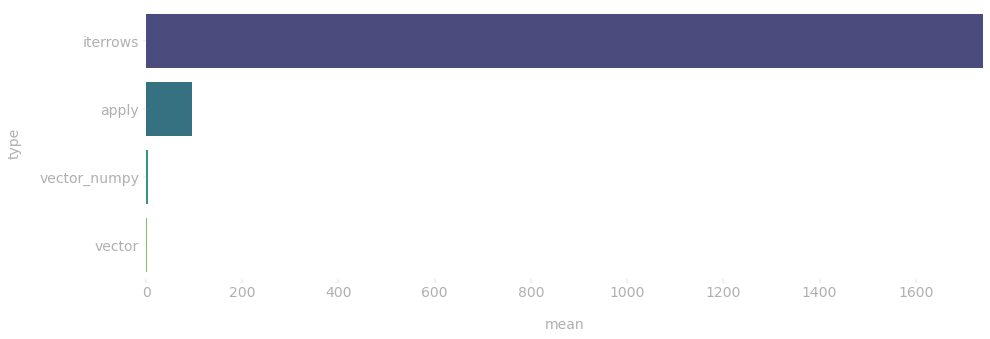

In [17]:
plt.figure(figsize=(15, 5))
sns.barplot(data=result_time, y='type', x='mean', palette='viridis');

In [18]:
def iterrows_check(df):
    result = []
    for index, row in df.iterrows():
        result.append(
            prepare_flg_special_car(row['production_date'],
                                    row['engine_power']))
    return result 


def apply_check(df):
    return df.apply(lambda x: prepare_flg_special_car(x['production_date'], x[
        'engine_power']),
        axis=1).to_list()


def vectorize_check(df):
    vector_prepare_flg_special_car = np.vectorize(prepare_flg_special_car)
    return vector_prepare_flg_special_car(df['production_date'],
                                          df['engine_power'])


def loc_check(df):
    data = df.copy()
    data['flg_special_car'] = 3
    data.loc[((data['production_date'] > 2020) & (data['engine_power'] > 400)),
           'flg_special_car'] = 1
    data.loc[((data['production_date'] < 2020) & (data['engine_power'] == 300)),
           'flg_special_car'] = 2
    return list(data['flg_special_car'])

In [19]:
kernels = [iterrows_check, apply_check, vectorize_check, loc_check]

vectorized_comparison = perfplot.bench(
    setup=lambda n: get_dataset(n),
    kernels=kernels,
    labels=[str(k.__name__) for k in kernels],
    n_range=[2**k for k in range(0, 24, 2)],
    xlabel='n_rows')

Output()

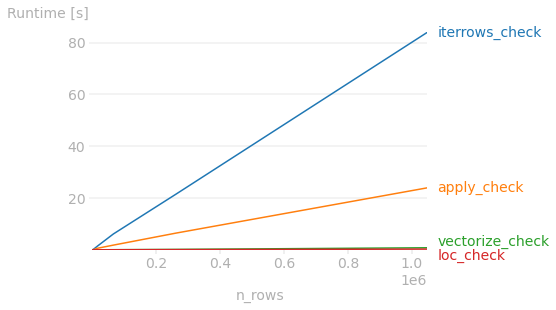

In [20]:
vectorized_comparison.plot(logx=False, logy=False)

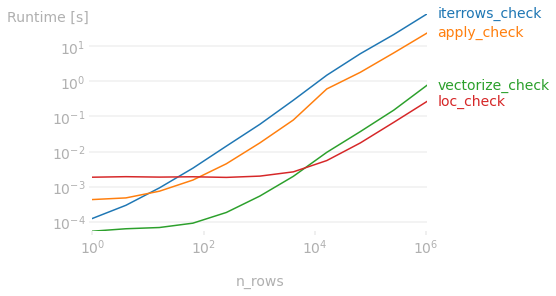

In [21]:
vectorized_comparison.plot(logx=True, logy=True, time_unit='s')
plt.show()

## Create bins

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model            5000 non-null   object 
 1   fuel             5000 non-null   object 
 2   production_date  5000 non-null   int64  
 3   transmission     5000 non-null   object 
 4   engine_power     5000 non-null   int64  
 5   price            5000 non-null   float64
 6   count            5000 non-null   int64  
 7   flg_special_car  5000 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 312.6+ KB


In [23]:
def create_bins_production(data):
    if data < 2023:
        return 'used'
    return 'new'

In [24]:
%%timeit
df['production_bins'] = df.apply(
    lambda x: create_bins_production(x['production_date']), axis=1)

68.8 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit
vector_create_bins_production = np.vectorize(create_bins_production)
df['production_bins'] = vector_create_bins_production(df['production_date'])

3.39 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit
df['production_bins'] = pd.cut(df['production_date'],
                               bins=[0, 2022, 2023],
                               labels=['used', 'new'])

1.52 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
result_time = pd.DataFrame({
    'type': ['apply', 'vector_numpy', 'pandas_cut'],
    'mean': [68.8, 3.39, 1.52]
})
result_time

,type,mean
0,apply,68.80
1,vector_numpy,3.39
2,pandas_cut,1.52


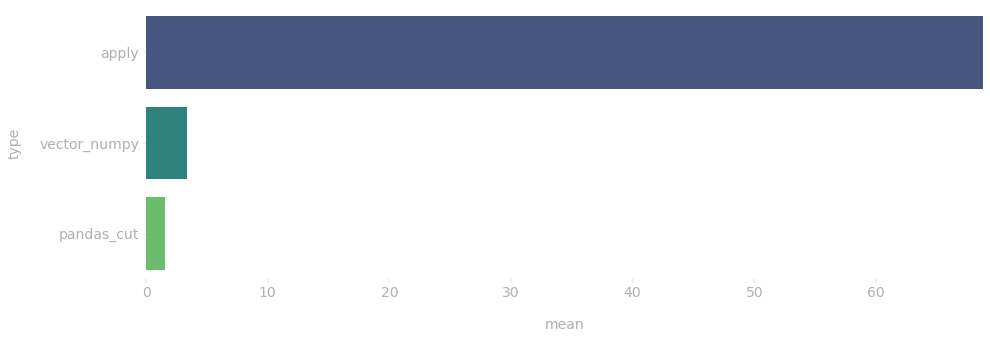

In [28]:
plt.figure(figsize=(15, 5))
sns.barplot(data=result_time, y='type', x='mean', palette='viridis');

In [29]:
def apply_check(df):
    return df.apply(lambda x: create_bins_production(x['production_date']),
                    axis=1)


def vectorize_check(df):
    vector_create_bins_production = np.vectorize(create_bins_production)
    return vector_create_bins_production(df['production_date'])


def cut_check(df):
    return pd.cut(df['production_date'],
                  bins=[0, 2022, 2023],
                  labels=['used', 'new'])

In [30]:
kernels = [apply_check, vectorize_check, cut_check]

vectorized_comparison = perfplot.bench(
    setup=lambda n: get_dataset(n),
    kernels=kernels,
    labels=[str(k.__name__) for k in kernels],
    n_range=[2**k for k in range(0, 24, 2)],
    equality_check=None,
    xlabel='n_rows')

Output()

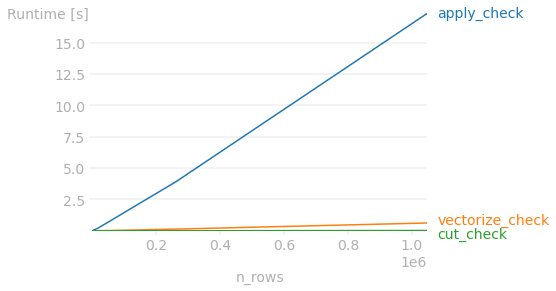

In [31]:
vectorized_comparison.plot(logx=False, logy=False)

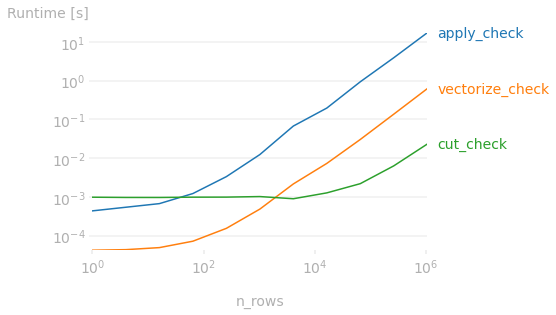

In [32]:
vectorized_comparison.plot(logx=True, logy=True, time_unit='s')
plt.show()